# Bayesian Linear Regression  

-----------

_Code by PJ Cabrera_  

## Project Guide

--------------

- [Project Overview](#overview)
- [Introduction and Review](#intro)
- [Coding Bayesian Linear Regression](#code)
- [Data Refresher](#data)

<a id = "overview"></a>
## Project Overview  

------------
The `pymc3` module is a standard for using Markov Chain Monte Carlo to estimate Bayesian derived distributions, in lieu of calculating exact integrals.  

- Calculation of Bayesian Posterior
- Calculating the $w_{MAP}$
- Estimating $\sigma^2$
- Calculating $\Sigma$  

**Motivation**: Bayesian regression allows us to quantify the uncertainty in our model building / the point estimates of our weights calculated in Least Squares Regression.  

**Problem**: Once again we will be using housing data to predict house price using living area and year built.  

**Data**: Our data comes from [Kaggle's House Prices Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). 

#### Imports:


In [2]:
### This cell imports the necessary modules and sets a few plotting parameters for display

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)  


<a id = "intro"></a>
### Introduction and Review.

Bayesian Regression comes with a different toolset than ordinary Linear Regression. In turn, that toolset demands a slightly different mindset. We start with a short review to hightlight the ways in which Bayesian thinking proceeds.

Consider a population whose age distribution is as follows:

| Age group | $\%$ of total population   |
|------|------|
|   $\le 35$  | $25 \%$|
| $36-65$ | $45 \%$ |
| $\ge 66$ | $30 \%$|

Say you know the following results of a study about YouTube viewing habits:

| Age group | $\%$ in this group that watch YouTube every day  |
|------|------|
|   $\le 35$  | $90 \%$|
| $36-65$ | $50 \%$  |
| $\ge 66$ | $10 \%$ |

**Prompt: If you know a user watches YouTube every day, what is the probability that they are under 35?**


We will start with a prior, then update that prior using the likelihood and the normalization from Bayes's formula. We define the following notation:

* $A$: YouTube watching habit
* $B$: Age
* $A = 1$: User watches YouTube every day 
* $A = 0$: User does not watch YouTube every day
* $B \le 35$: User has age between 0 and 35
* $36 \le B \le 65$: User has age between 36 and 65
* $B \ge  66$: User has age greater than 65

The prior can be read from the first table: 

$$P(B \le 35) = 0.25$$

We are looking to calculate the posterior probability:

$$P(B \le 35|A = 1)$$

With Bayes's formula:

$$P(B|A) = \frac{P(A|B)P(B)}{P(A)}$$

For our question:

$$P(B \le 35|A=1) = \frac{P(A=1|B \le 35)*P(B \le 35)}{P(A=1)}$$  

While the tables do not contain the value of $P(A=1)$ it may be calculated:  

$P(A=1) = $  


$\ \ \ \ \ \ \ \ \ \ \ \ P(A=1| B\le 35)*P(B\le 35) \ + $  

$\ \ \ \ \ \ \ \ \ \ \ \ P(A=1|35<B<65)* P(35<B<65)\  + $  

$\ \ \ \ \ \ \ \ \ \ \ \ P(A=1|B\ge 65)*P(B\ge 65)$


In [7]:

### ACCEPT three inputs
### Two floats: the likelihood and the prior
### One list of tuples, where each tuple has two values corresponding to:
### ### ( P(Bn) , P(A|Bn) )
### ### ### Assume the list of tuples accounts for all potential values of B
### ### ### And that those values of B are all mutually exclusive.
### The list of tuples allows for the calculation of normalization constant.

### RETURN a float corresponding to the posterior probability

def calc_posterior(likelihood, prior, norm_list):
    """
    Calculate the posterior probability given likelihood,
    prior, and normalization
    
    Positional Arguments:
        likelihood -- float, between 0 and 1
        prior -- float, between 0 and 1
        norm_list -- list of tuples, each tuple has two values
            the first value corresponding to the probability of a value of "b"
            the second value corresponding to the probability of 
                a value of "a" given that value of "b"
    Example:
        likelihood = .8
        prior = .3
        norm_list = [(.25 , .9), (.5, .5), (.25,.2)]
        print(calc_posterior(likelihood, prior, norm_list))
        # --> 0.45714285714285713
    """
    sum_of_products_of_norms = 0
    for norm in norm_list:
        sum_of_products_of_norms += norm[0] * norm[1]
    return (likelihood * prior) / sum_of_products_of_norms

likelihood = .8
prior = .3
norm_list = [(.25 , .9), (.5, .5), (.25,.2)]
print(calc_posterior(likelihood, prior, norm_list))

0.45714285714285713


#### Applicability

In real life, this situation corresponds to:  
1. Surveying people and asking them two questions (what's your age? do you watch YouTube every day?), then tabulating the percentage of each age group that watch YouTube everyday.
2. After having collected that data, observing the anonymized watching habits of a set of different users (not the survey takers) - without access to additional demographic info -  and using the above survey to derive a probability for the anonymized users' age.

### Bayesian Linear Regression

In Bayesian Linear Regression, our prior expresses a belief about the parameters of linear regression we wish to calculate, namely that the linear coefficient vector should have a small absolute value, and that deviations from zero should be Gaussian. This prior is mathematically equivalent to the Ridge Regression condition.

So the question we will now ask is: conditioned on the data, how does our belief regarding the parameters of linear regression change? 

This is the same prior-to-posterior calculation of the above exercise.  

Bayes' Rule:

$P(B|A) = \frac{P(A|B)\ P(B)}{P(A)}$,

For linear Regression:

$p(w | y, X) = \frac{p(y | w, X)\ p(w)}{p(y | X)}$  

What do we know, and what do we not know?

* $p(w) = N(0, \lambda^{-1} I)$: That's the prior on $w$ --- Known.  


* $p(y | w, X) = N(X w, \sigma^2 I)$: That's the likelihood expression --- Known.  


* $p(y | X)$: That's the marginal probability of $y$ --- NOT KNOWN

Rewriting the marginal probability in detail, using an integral instead of a sum - since $w$ is a continuous variable.

$p(y | X) = \int_{\mathbb{R^d}} p(y, w | X)\ dw$

$\ \ \ \ \ \ \ \ \ \ = \int_{\mathbb{R^d}}\ p(y | w, X)\  p(w)\ dw$


At this point approximation is frequently required as the above integral usually has no closed form.  

<a id= "code"></a>

### Coding Bayesian Linear Regression

In lecture, we obtained an equation for the posterior probability of $w$, the linear regression parameter vector:

$$p(w|y, X) = N(w|\mu, \Sigma)$$

where

$$\Sigma = (\lambda \ I + \sigma^{- 2}\ X^T\ X)^{−1}$$

$$\mu = (\lambda \ \sigma^2 I + X^T\ X)^{-1}\ X^T y ⇐ w_{MAP}$$



Recall that $\sigma^2$ is a parameter characterizing the deviation of the data from the line defined by $Xw$. While we don't know the true underlying parameter, we can estimate it by using the empirical deviation:

$$\sigma^2 \approx \hat{\sigma}^2 = \frac{1}{n − d}\Sigma_{i=1}^n ( y_i − X_i w )^2$$  
Where $w$ in the above is the $w_{LeastSquares} = (X^T\ X)^{-1}\ X^T y$


-----------------------
When it comes to prediction:  
$p( y_0|x_0,y,X) = N(y_0|\mu_0,\sigma^2_0)$  
$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \mu_0 = x^T_0\mu$  
$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \sigma^2_0 = \sigma^2 + x_0^T\Sigma x_0$  

-----------------------------
This section will involve coding five functions:
- `x_preprocess`
- `calculate_map_coefficients`
- `estimate_data_noise`
- `calc_post_cov_mtx`
- `predict` 

Such that the functions `fit_bayes_reg` and `predict_bayes_reg` - outlined below - will work correctly. 

In [8]:
def fit_bayes_reg(input_x, output_y, lambda_param):
    
    # Ensure correct shape of X, add column of 1's for intercept
    aug_x = x_preprocess(input_x) # <----
    
    # Calculate least-squares weights
    ml_weights = calculate_map_coefficients(aug_x, output_y, 0, 0) # <----
        
    # Estimate sigma^2 from observations
    sigma = estimate_data_noise(aug_x, output_y, ml_weights) # <----
    
    # Calculate MAP weights
    weights = calculate_map_coefficients(aug_x, output_y, lambda_param, sigma) # <---- 

    
    # Create posterior covariance matrix
    big_sig = calc_post_cov_mtx(aug_x, sigma, lambda_param) # <----
    
    return weights, big_sig

def predict_bayes_reg(x_obs, weights, big_sig):
    
    # Ensure correct shape of X, add 1's for intercept
    aug_x = x_preprocess(x_obs) # <----
    
    # find mean / variance parameters describing prediction for data
    mu_0, sig_sq_0 = predict(aug_x, weights, big_sig) # <----
    
    return mu_0, sig_sq_0

#### X-matrix preprocessing

In [9]:

### ACCEPT one input, a numpy array
### ### Array may be one or two dimensions

### If input is two dimensional, make sure there are more rows than columns
### ### Then prepend a column of ones for intercept term
### If input is one-dimensional, prepend a one

### RETURN a numpy array, prepared as described above,
### which is now ready for matrix multiplication with regression weights

def x_preprocess(input_x):
    """
    Reshape the input (if needed), and prepend a "1" to every observation
    
    Positional Argument:
        input_x -- a numpy array, one- or two-dimensional
    
    Example:
        input1 = np.array([[2,3,6,9],[4,5,7,10]])
        input2 = np.array([2,3,6])
        input3 = np.array([[2,4],[3,5],[6,7],[9,10]])
        
        for i in [input1, input2, input3]:
            print(x_preprocess(i), "\n")
            
        # -->[[ 1.  2.  4.]
              [ 1.  3.  5.]
              [ 1.  6.  7.]
              [ 1.  9. 10.]] 

            [1 2 3 6] 

            [[ 1.  2.  4.]
             [ 1.  3.  5.]
             [ 1.  6.  7.]
             [ 1.  9. 10.]] 

    Assumptions:
        Assume that if the input is two dimensional, that the observations are more numerous
            than the features, and thus, the observations should be the rows, and features the columns
    """    
    if len(input_x.shape) == 2:
        # step 1: transpose input_x if necessary
        n = input_x.shape[0]
        p = input_x.shape[1]
        if n > p:
            X = input_x
        else:
            X = input_x.transpose()
    
        # step 2: prepend n-by-1 column of ones to X
        oneses = np.ones(shape=(X.shape[0],1))
        X = np.concatenate((oneses, X), 1)
    else:
        X = np.insert(input_x,0,1)
    
    return X


input1 = np.array([[2,3,6,9],[4,5,7,10]])
input2 = np.array([2,3,6])
input3 = np.array([[2,4],[3,5],[6,7],[9,10]])

for i in [input1, input2, input3]:
    print(x_preprocess(i), "\n")

[[ 1.  2.  4.]
 [ 1.  3.  5.]
 [ 1.  6.  7.]
 [ 1.  9. 10.]] 

[1 2 3 6] 

[[ 1.  2.  4.]
 [ 1.  3.  5.]
 [ 1.  6.  7.]
 [ 1.  9. 10.]] 




#### MAP Coefficients:

$$\mu = (\lambda \ \sigma^2 I + X^T\ X)^{-1}\ X^T y = w_{MAP}$$ 

In [10]:

### ACCEPT four inputs:
### Two numpy arrays; an X-matrix and y-vector
### Two positive numbers, a lambda parameter, and value for sigma^2

### RETURN a 1-d numpy vector of weights.

### ASSUME your x-matrix has been preprocessed:
### observations are in rows, features in columns, and a column of 1's prepended.

### Use the above equation to calculate the MAP weights.
### ### This will involve creating the lambda matrix.
### ### The MAP weights are equal to the Ridge Regression weights

### NB: `.shape`, `np.matmul`, `np.linalg.inv`,
### `np.ones`, `np.identity` and `np.transpose` will be valuable.

### If either the "sigma" or "lambda_param" are equal to 0, the return will be
### equivalent to ordinary least squares.


def calculate_map_coefficients(aug_x, output_y, lambda_param, sigma):
    """
    Calculate the maximum a posteriori LR parameters
    
     Positional arguments:
        aug_x -- x-matrix of training input data, augmented with column of 1's
        output_y -- vector of training output values
        lambda_param -- positive number; lambda parameter that
            controls how heavily to penalize large coefficient values
        sigma -- data noise estimate
        
    Example:
        output_y = np.array([208500, 181500, 223500, 
                             140000, 250000, 143000, 
                             307000, 200000, 129900, 
                             118000])
                             
        aug_x = np. array([[   1., 1710., 2003.],
                           [   1., 1262., 1976.],
                           [   1., 1786., 2001.],
                           [   1., 1717., 1915.],
                           [   1., 2198., 2000.],
                           [   1., 1362., 1993.],
                           [   1., 1694., 2004.],
                           [   1., 2090., 1973.],
                           [   1., 1774., 1931.],
                           [   1., 1077., 1939.]])
                           
        lambda_param = 0.01
        
        sigma = 1000
        
        map_coef = calculate_map_coefficients(aug_x, output_y, 
                                             lambda_param, sigma)
                                             
        ml_coef = calculate_map_coefficients(aug_x, output_y, 0,0)
        
        print(map_coef)
        # --> np.array([-576.67947107   77.45913349   31.50189177])
        
        print(ml_coef)
        #--> np.array([-2.29223802e+06  5.92536529e+01  1.20780450e+03])
        
    Assumptions:
        -- output_y is a vector whose length is the same as the
        number of rows in input_x
        -- input_x has more observations than it does features.
        -- lambda_param has a value greater than 0
    """
    lambda_sigma_i = lambda_param * sigma * np.identity(aug_x.shape[1])
    coefs = np.linalg.inv(aug_x.transpose().dot(aug_x) + lambda_sigma_i).dot(aug_x.transpose()).dot(output_y)    
    return coefs

output_y = np.array([208500, 181500, 223500, 
                     140000, 250000, 143000, 
                     307000, 200000, 129900, 
                     118000])
        
aug_x = np. array([[   1., 1710., 2003.],
                   [   1., 1262., 1976.],
                   [   1., 1786., 2001.],
                   [   1., 1717., 1915.],
                   [   1., 2198., 2000.],
                   [   1., 1362., 1993.],
                   [   1., 1694., 2004.],
                   [   1., 2090., 1973.],
                   [   1., 1774., 1931.],
                   [   1., 1077., 1939.]])
        
lambda_param = 0.01

sigma = 1000

map_coef = calculate_map_coefficients(aug_x, output_y, 
                                     lambda_param, sigma)

ml_coef = calculate_map_coefficients(aug_x, output_y, 0,0)

print(map_coef)
print(ml_coef)

[-576.67947106   77.45913349   31.50189177]
[-2.29223802e+06  5.92536529e+01  1.20780450e+03]


#### Estimate Data Noise
$$\sigma^2 \approx \hat{\sigma}^2 = \frac{1}{n − d}\Sigma_{i=1}^n ( y_i − X_i w )^2$$  

In [11]:

### ACCEPT three inputs, all numpy arrays
### One matrix coresponding to the augmented x-matrix
### Two vectors, one of the y-target, and one of ML weights.

### RETURN the empirical data noise estimate: sigma^2. Calculated with equation given above.

### NB: "n" is the number of observations in X (rows)
### "d" is the number of features in aug_x (columns) 

def estimate_data_noise(aug_x, output_y, weights):
    """Return empirical data noise estimate \sigma^2
    Use the LR weights in the equation supplied above
    
    Positional arguments:
        aug_x -- matrix of training input data
        output_y -- vector of training output values
        weights -- vector of LR weights calculated from output_y and aug_x
        
        
    Example:
        output_y = np.array([208500, 181500, 223500, 
                                140000, 250000, 143000, 
                                307000, 200000, 129900, 
                                118000])
        aug_x = np. array([[   1., 1710., 2003.],
                           [   1., 1262., 1976.],
                           [   1., 1786., 2001.],
                           [   1., 1717., 1915.],
                           [   1., 2198., 2000.],
                           [   1., 1362., 1993.],
                           [   1., 1694., 2004.],
                           [   1., 2090., 1973.],
                           [   1., 1774., 1931.],
                           [   1., 1077., 1939.]])
        
        ml_weights = calculate_map_coefficients(aug_x, output_y, 0, 0)
        
        print(ml_weights)
        # --> [-2.29223802e+06  5.92536529e+01  1.20780450e+03]
        
        sig2 = estimate_data_noise(aug_x, output_y, ml_weights)
        print(sig2)
        #--> 1471223687.1593
        
    Assumptions:
        -- training_input_y is a vector whose length is the same as the
        number of rows in training_x
        -- input x has more observations than it does features.
        -- lambda_param has a value greater than 0
    """
    n,d = aug_x.shape
    return (1 / (n - d)) * sum((output_y[i] - np.matmul(aug_x[i],weights))**2 for i in range(n))

output_y = np.array([208500, 181500, 223500, 
                     140000, 250000, 143000, 
                     307000, 200000, 129900, 
                     118000])
aug_x = np. array([[   1., 1710., 2003.],
                   [   1., 1262., 1976.],
                   [   1., 1786., 2001.],
                   [   1., 1717., 1915.],
                   [   1., 2198., 2000.],
                   [   1., 1362., 1993.],
                   [   1., 1694., 2004.],
                   [   1., 2090., 1973.],
                   [   1., 1774., 1931.],
                   [   1., 1077., 1939.]])

ml_weights = calculate_map_coefficients(aug_x, output_y, 0, 0)

print(ml_weights)
# --> [-2.29223802e+06  5.92536529e+01  1.20780450e+03]

sig2 = estimate_data_noise(aug_x, output_y, ml_weights)
print(sig2)
#--> 1471223687.1593

[-2.29223802e+06  5.92536529e+01  1.20780450e+03]
1471223687.159289


#### Posterier Covariance  

$$\Sigma = (\lambda \ I + \sigma^{- 2}\ X^T\ X)^{−1}$$

In [12]:

### ACCEPT three inputs:
### One numpy array for the augmented x-matrix
### Two floats for sigma-squared and a lambda_param

### Calculate the covariance matrix of the posterior (capital sigma), via equation given above.
### RETURN that matrix.

def calc_post_cov_mtx(aug_x, sigma, lambda_param):
    """
    Calculate the covariance of the posterior for Bayesian parameters
    
    Positional arguments:
        aug_x -- matrix of training input data; preprocessed
        sigma -- estimation of sigma^2
        lambda_param -- lambda parameter that controls how heavily
        to penalize large weight values
        
    Example:
        output_y = np.array([208500, 181500, 223500, 
                                140000, 250000, 143000, 
                                307000, 200000, 129900, 
                                118000])
        aug_x = np. array([[   1., 1710., 2003.],
                           [   1., 1262., 1976.],
                           [   1., 1786., 2001.],
                           [   1., 1717., 1915.],
                           [   1., 2198., 2000.],
                           [   1., 1362., 1993.],
                           [   1., 1694., 2004.],
                           [   1., 2090., 1973.],
                           [   1., 1774., 1931.],
                           [   1., 1077., 1939.]])
        lambda_param = 0.01
        
        ml_weights = calculate_map_coefficients(aug_x, output_y,0,0)
        
        sigma = estimate_data_noise(aug_x, output_y, ml_weights)
        
        print(calc_post_cov_mtx(aug_x, sigma, lambda_param))
        # --> [[ 9.99999874e+01 -1.95016334e-02 -2.48082095e-02]
               [-1.95016334e-02  6.28700339e+01 -3.85675510e+01]
               [-2.48082095e-02 -3.85675510e+01  5.10719826e+01]]

    Assumptions:
        -- training_input_y is a vector whose length is the same as the
        number of rows in training_x
        -- lambda_param has a value greater than 0
    
    """
    lambda_i = lambda_param * np.identity(aug_x.shape[1])
    return np.linalg.inv(aug_x.transpose().dot(aug_x).dot(1/sigma) + lambda_i)

output_y = np.array([208500, 181500, 223500, 
                     140000, 250000, 143000, 
                     307000, 200000, 129900, 
                     118000])
aug_x = np. array([[   1., 1710., 2003.],
                   [   1., 1262., 1976.],
                   [   1., 1786., 2001.],
                   [   1., 1717., 1915.],
                   [   1., 2198., 2000.],
                   [   1., 1362., 1993.],
                   [   1., 1694., 2004.],
                   [   1., 2090., 1973.],
                   [   1., 1774., 1931.],
                   [   1., 1077., 1939.]])
lambda_param = 0.01

ml_weights = calculate_map_coefficients(aug_x, output_y,0,0)

sigma = estimate_data_noise(aug_x, output_y, ml_weights)

print(calc_post_cov_mtx(aug_x, sigma, lambda_param))
# --> [[ 9.99999874e+01 -1.95016334e-02 -2.48082095e-02]
#[-1.95016334e-02  6.28700339e+01 -3.85675510e+01]
#[-2.48082095e-02 -3.85675510e+01  5.10719826e+01]]

[[ 9.99999874e+01 -1.95016334e-02 -2.48082095e-02]
 [-1.95016334e-02  6.28700339e+01 -3.85675510e+01]
 [-2.48082095e-02 -3.85675510e+01  5.10719826e+01]]


Now we have functions for
$$\Sigma = (\lambda \ I + \sigma^{- 2}\ X^T\ X)^{−1}$$
$$\mu = w_{map}=(\lambda\ \sigma^2 I+X^TX)^{-1}X^Ty$$

And thus, $p(w|y, X) = N(w|\mu, \Sigma)$, the posterior distribution of the linear regression parameters may be described.

When we want to predict an unknown value, $y_0$ given observations $x_0$:  
$p( y_0|x_0,y,X) = N(y_0|\mu_0,\sigma^2_0)$  
$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \mu_0 = x^T_0\mu$  
$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \sigma^2_0 = \sigma^2 + x_0^T\Sigma x_0$  



In [13]:

### ACCEPT four inputs, three numpy arrays, and one number:
### A 1-dimensional array corresponding to an augmented_x vector.
### A vector corresponding to the MAP weights, or "mu"
### A square matrix for the "big_sigma" term
### A positive number for the "sigma_squared" term

### Using the above equations

### RETURN mu_0 and sigma_squared_0 - a point estimate and variance
### for the prediction for x.

def predict( aug_x, weights, big_sig, sigma):
    """
    Calculate point estimates and uncertainty for new values of x
    
    Positional Arguments:
        aug_x -- augmented matrix of observations for predictions
        weights -- MAP weights calculated from Bayesian LR
        big_sig -- The posterior covarience matrix, from Bayesian LR
        sigma -- The observed uncertainty in Bayesian LR
        
    Example:
        output_y = np.array([208500, 181500, 223500, 
                                140000, 250000, 143000, 
                                307000, 200000, 129900, 
                                118000])
                                
        aug_x = np. array([[   1., 1710., 2003.],
                           [   1., 1262., 1976.],
                           [   1., 1786., 2001.],
                           [   1., 1717., 1915.],
                           [   1., 2198., 2000.],
                           [   1., 1362., 1993.],
                           [   1., 1694., 2004.],
                           [   1., 2090., 1973.],
                           [   1., 1774., 1931.],
                           [   1., 1077., 1939.]])
        lambda_param = 0.01
        
        ml_weights = calculate_map_coefficients(aug_x, output_y,0,0)
        
        sigma = estimate_data_noise(aug_x, output_y, ml_weights)
        
        map_weights = calculate_map_coefficients(aug_x, output_y, lambda_param, sigma)
        
        big_sig = calc_post_cov_mtx(aug_x, sigma, lambda_param)
        
        to_pred2 = np.array([1,1700,1980])
        
        print(predict(to_pred2, map_weights, big_sig, sigma))
        #-->(158741.6306608729, 1593503867.9060116)
        
    """
    mu_0 = np.matmul(aug_x,weights)
    sigma_squared_0 = sigma + (aug_x.transpose().dot(big_sig)).dot(aug_x)
    
    return mu_0, sigma_squared_0

output_y = np.array([208500, 181500, 223500, 
                     140000, 250000, 143000, 
                     307000, 200000, 129900, 
                     118000])

aug_x = np. array([[   1., 1710., 2003.],
                   [   1., 1262., 1976.],
                   [   1., 1786., 2001.],
                   [   1., 1717., 1915.],
                   [   1., 2198., 2000.],
                   [   1., 1362., 1993.],
                   [   1., 1694., 2004.],
                   [   1., 2090., 1973.],
                   [   1., 1774., 1931.],
                   [   1., 1077., 1939.]])
lambda_param = 0.01

ml_weights = calculate_map_coefficients(aug_x, output_y,0,0)

sigma = estimate_data_noise(aug_x, output_y, ml_weights)

map_weights = calculate_map_coefficients(aug_x, output_y, lambda_param, sigma)

big_sig = calc_post_cov_mtx(aug_x, sigma, lambda_param)

to_pred2 = np.array([1,1700,1980])

print(predict(to_pred2, map_weights, big_sig, sigma))
#-->(158741.6306608729, 1593503867.9060116)

(158741.63066087314, 1593503867.9059994)


<a id = "data"></a>
### Data Refresher  

Once again, we will be using the Bayesian regression functions on house price data. Observations from this data will be used to test the functions you have created.

In [14]:
### Read in the data
tr_path = './house-prices/train.csv'
data = pd.read_csv(tr_path)  

### The .head() function shows the first few lines of data for perspecitve
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


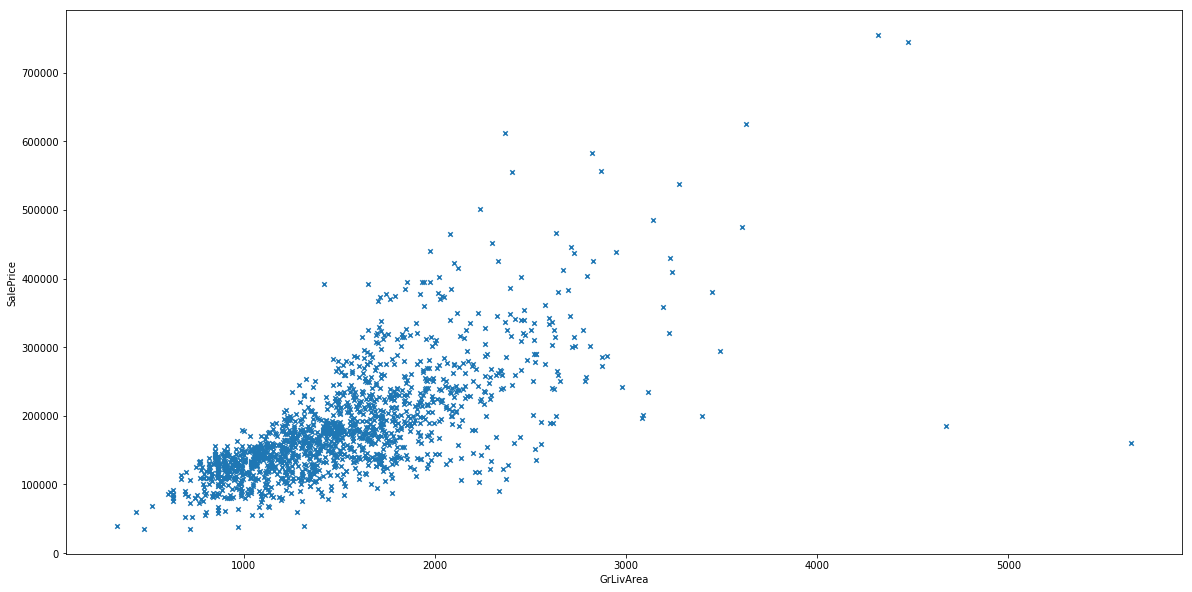

In [15]:
data.plot('GrLivArea', 'SalePrice', kind = 'scatter', marker = 'x');

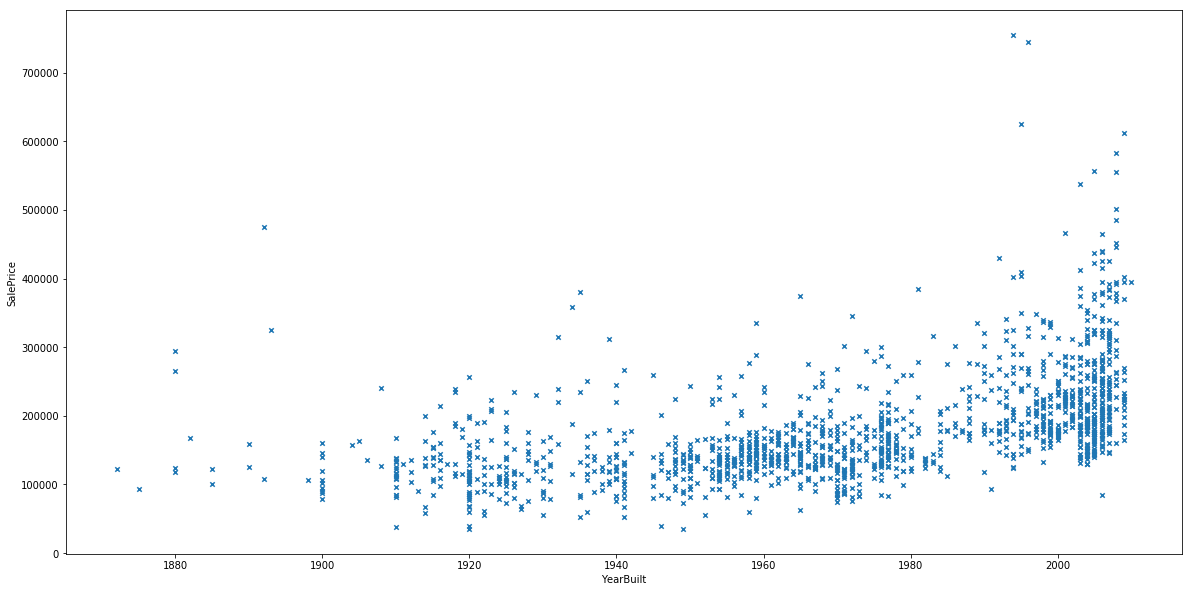

In [16]:
data.plot('YearBuilt', 'SalePrice', kind = 'scatter', marker = 'x');

#### On Housing Data

Use your functions above to return a $\Sigma$ and $\mu$ for our housing dataset.

Use "SalePrice" as the target, and "GrLivArea" and "YearBuilt" as predictors. Keep "GrLivArea" and "YearBuild", in that order. (Order is important for grading.)  

e.g.
```
input_x = data[['GrLivArea, 'YearBuilt']].values
```

Use .1 for $\lambda$ 

Below, return the $\mu$ vector to the variable "mu"  

Return the $\Sigma$ matrix to the variable "big_sig"

Remember, the `fit_bayes_reg` function should work if you defined the above equations correctly.

In [17]:

"""
Example:
    input_x = data[['GrLivArea','YearBuilt']].head(100).values
    output_y = data['SalePrice'].head(100).values
    lambda_param = .1
    
    < --- CODE BLOCK --->
    
    print(mu)
    #--> np.array([2.10423243e-02, 4.10449281e+01, 4.22635006e+01])
    print(big_sig)
    #--> 
    np.array([[ 9.99999861e+00, -1.75179751e-03, -2.74204060e-03],
              [-1.75179751e-03,  6.50420674e+00, -3.47271893e+00],
              [-2.74204060e-03, -3.47271893e+00,  4.60297584e+00]])
"""
lambda_param = .1
x = data[['GrLivArea','YearBuilt']].values
y = data['SalePrice'].values

X = x_preprocess(x)

ml_weights = calculate_map_coefficients(X, y, 0, 0)

sigma = estimate_data_noise(X, y, ml_weights)

mu = calculate_map_coefficients(X, y, lambda_param, sigma)

big_sig = calc_post_cov_mtx(X, sigma, lambda_param)

print(mu)

print(big_sig)


[1.30269779e-02 7.61463982e+01 3.22497911e+01]
[[ 9.99999791e+00 -1.08590728e-03 -4.07900078e-03]
 [-1.08590728e-03  2.95544603e+00 -2.18957015e+00]
 [-4.07900078e-03 -2.18957015e+00  1.99320832e+00]]
